In [2]:
import cv2
import numpy as np
import math
# from src.utils import *
from matplotlib import pyplot as plt
from utils import *


%matplotlib inline
%load_ext autoreload
%autoreload 2

/home/leo/PycharmProjects/video-transition-detector/jpNotebook/utils.py:4: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/usr/lib/python3.5/runpy.py", line 184, in _run_module_as_main
    "__main__", mod_spec)
  File "/usr/lib/python3.5/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/leo/.local/share/virtualenvs/video-transition-detector-48b9e7Mw/lib/python3.5/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/leo/.local/share/virtualenvs/video-transition-detector-48b9e7Mw/lib/python3.5/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/leo/.local/share/virtualenvs/vide

Width: 112
Height: 112
Frame Count: 84
<class 'numpy.ndarray'>


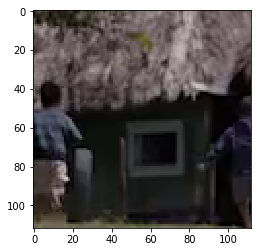

In [3]:
# test the basic information of video
video_path = '../media/video_3_down_wipe.mp4'
cap = cv2.VideoCapture(video_path)
if not cap.isOpened():
    raise FileNotFoundError('File {} not found'.format(video_path))

height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
print("Width: {}".format(width))
print("Height: {}".format(height))
print("Frame Count: {}".format(frame_count))
# show RGB first frame
cap.set(cv2.CAP_PROP_POS_FRAMES, 0)
ret, some_frame = cap.read()
plt.imshow(cv2.cvtColor(some_frame, cv2.COLOR_BGR2RGB))
print(type(some_frame))

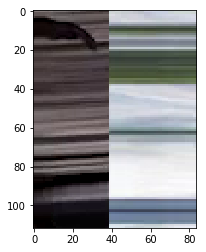

In [32]:
mode = 'row'

# convert each column/row to STI
if mode == 'row':
    stis = np.ndarray((height, width, frame_count, 3), dtype=np.uint8)
    for i in range(height):
        stis[i] = to_sti(cap, 'row', i)
elif mode == 'column':
    stis = np.ndarray((width, height, frame_count, 3), dtype=np.uint8)
    for i in range(width):
        stis[i] = to_sti(cap, 'column', i)
    
sti_rgb = cv2.cvtColor(stis[43], cv2.COLOR_BGR2RGB)
plt.imshow(sti_rgb)

In [33]:
# BGR -> GR
stis_rg = np.ndarray(list(stis.shape[:-1]) + [2], dtype=np.float32)
for i in range(width):
    stis_rg[i] = bgr_to_rg(stis[i])

In [34]:
# implements histogram intersection on GR color channels
threshold = 0.8
wipe_positions, wipe_frames = intersection(stis_rg, threshold)

The number of transition detected: 142


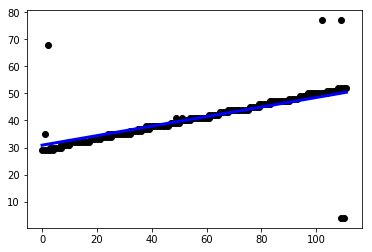

start/end frame: [31. 50.]
Mean Square Error: 51.50360176661075


In [35]:
# 
if mode == 'column':
    width_or_height = width
elif mode == 'row':
    width_or_height = height
    
linear_regression_column(wipe_positions, wipe_frames, width_or_height)
